In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tqdm import tqdm

In [2]:
T_dataset = pd.read_csv("/home/sa42/data/glac/T_models/T.csv")
TT_dataset = pd.read_csv("/home/sa42/data/glac/T_models/TT.csv")
TTT_dataset = pd.read_csv("/home/sa42/data/glac/T_models/TTT.csv")

T_dataset = T_dataset.drop(["GLACIER_DB",
                            "POLITICAL_UNIT",
                            "GLACIER_ID",
                            "GLACIER_NAME",
                            "NUMBER_OF_SURVEY_POINTS",
                            "NUMBER_OF_SURVEY_PROFILES",
                            "TOTAL_LENGTH_OF_SURVEY_PROFILES",
                            "INTERPOLATION_METHOD",
                            "INVESTIGATOR",
                            "SPONSORING_AGENCY",
                            "ELEVATION_DATE",
                            "SURVEY_METHOD_DETAILS",
                            "SURVEY_METHOD",
                            "SURVEY_DATE",
                            "MEAN_THICKNESS",
                            "AREA",
                            "MEAN_THICKNESS_UNCERTAINTY",
                            "MAXIMUM_THICKNESS",
                            "MAX_THICKNESS_UNCERTAINTY",
                            "DATA_FLAG", 
                            "REMARKS",
                            "REFERENCES",
                            "MEAN_SLOPE"
                           ], axis=1)
T_dataset = T_dataset.dropna()

TT_dataset = TT_dataset.drop(["POLITICAL_UNIT",
                              "GLACIER_NAME",
                              "SURVEY_DATE",
                              "MEAN_THICKNESS_UNCERTAINTY",
                              "MAXIMUM_THICKNESS",
                              "MAX_THICKNESS_UNCERTAINTY",
                              "DATA_FLAG",
                              "REMARKS"],
                             axis=1)
TT_dataset = TT_dataset.dropna()

TTT_dataset = TTT_dataset.drop(["POLITICAL_UNIT",
                                "GLACIER_NAME",
                                "SURVEY_DATE",
                                "PROFILE_ID",
                                "THICKNESS_UNCERTAINTY",
                                "DATA_FLAG",
                                "REMARKS",
                                "POINT_ID"
                               ], axis=1)
TTT_dataset = TTT_dataset.dropna()

T = pd.DataFrame(T_dataset)
T.rename(columns = {"LAT":"LAT_CENT",
                    "LON":"LON_CENT",
                    "AREA":"T_AREA"},
         inplace = True)

TT = pd.DataFrame(TT_dataset)
TT.rename(columns = {"LOWER_BOUND":"TT_LOWER_BOUND",
                     "UPPER_BOUND":"TT_UPPER_BOUND",
                     "AREA":"TT_AREA",
                     "MEAN_SLOPE":"TT_MEAN_SLOPE",
#                      "MEAN_THICKNESS":"TT_MEAN_THICKNESS"
                    },
          inplace = True)

TTT = pd.DataFrame(TTT_dataset)
TTT.rename(columns = {"ELEVATION":"POINT_ELEVATION",
                      "THICKNESS":"POINT_THICKNESS"},
           inplace = True)

TTT_plu = pd.merge(T, TTT, how="inner", on=["GlaThiDa_ID"])

TTT_plus = pd.merge(TT,TTT_plu, how="inner", on=["GlaThiDa_ID"])
TTT_plus.dropna()

TTT_plus = TTT_plus.drop("GlaThiDa_ID",axis=1)
# TTT_plus = TTT_plus.drop("TT_MEAN_THICKNESS",axis=1)
TTT_plus = TTT_plus.drop("POINT_LAT",axis=1)
TTT_plus = TTT_plus.drop("POINT_LON",axis=1)
# TTT_plus = TTT_plus.drop("TT_LOWER_BOUND",axis=1)
# TTT_plus = TTT_plus.drop("TT_UPPER_BOUND",axis=1)
TTT_plus = TTT_plus.drop("POINT_ELEVATION",axis=1)
TTT_plus = TTT_plus.drop("POINT_THICKNESS",axis=1)
TTT_plus = TTT_plus.drop("LAT_CENT",axis=1)
TTT_plus = TTT_plus.drop("LON_CENT",axis=1)

t = TTT_plus.index[TTT_plus["MEAN_THICKNESS"]>0]
TTT_plus = TTT_plus.loc[t]

/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (2,4,5,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
#split the dataset into test and train data sets.
train_dataset = TTT_plus.sample(frac=0.8, random_state=0)
test_dataset = TTT_plus.drop(train_dataset.index)

#separate out features - what will be trained to predict desired attribute
train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop("MEAN_THICKNESS")
test_labels = test_features.pop("MEAN_THICKNESS")

In [4]:
#establish variables and normalization layers
variable_list = {
#                  'TT_LOWER_BOUND',
#                  'TT_UPPER_BOUND',
                 'TT_AREA',
                 'TT_MEAN_SLOPE',
#                  'LAT_CENT',
#                  'LON_CENT'
                 }
normalizer = {}
for variable_name in variable_list:
    normalizer[variable_name] = preprocessing.Normalization(input_shape=[1,], axis=None)
    normalizer[variable_name].adapt(np.array(train_features[variable_name]))
    
normalizer['ALL'] = preprocessing.Normalization(axis=-1)
normalizer['ALL'].adapt(np.array(train_features))

2022-03-15 16:12:22.529627: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-15 16:12:22.529668: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sermeq.ess.washington.edu): /proc/driver/nvidia/version does not exist
2022-03-15 16:12:22.530114: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
def build_dnn_model(norm):
    model = keras.Sequential([
              norm,
              layers.Dense(64, activation='relu'),
              layers.Dense(64, activation='relu'),
              layers.Dense(1) ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    
    return model

def dnn_test_results(feature_name):
    dnn_test_results[feature_name] = dnn_model.evaluate(
        test_features[feature_name],
        test_labels, verbose=0)
    
def plot_loss(history):
#     plt.subplots(figsize=(10,5))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #   plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    

In [6]:
dnn_test_results = {}
dnn_model = {}
dnn_history = {}
dnn_results = {}
dnn_history_full = {}

In [7]:
dnn_full_model = build_dnn_model(normalizer['ALL'])

In [8]:
%%time
dnn_history_full = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, 
    epochs=100)

CPU times: user 39min 16s, sys: 10min 28s, total: 49min 45s
Wall time: 4min 56s


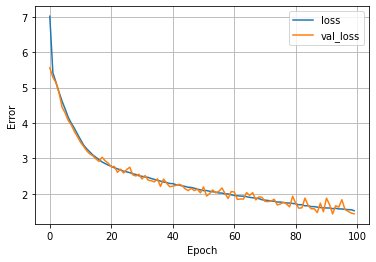

In [9]:
plot_loss(dnn_history_full)

In [10]:
dnn_test_results["dnn_full_model"] = dnn_full_model.evaluate(
    test_features,
    test_labels, verbose=0)

dnn_test_results

{'dnn_full_model': 1.3750145435333252}

Text(0, 0.5, 'Model Thickness(m)')

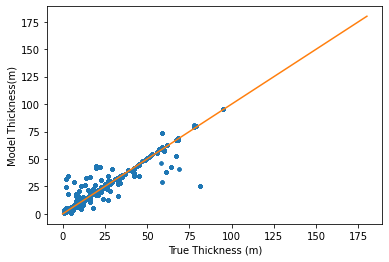

In [11]:
y = dnn_full_model.predict(test_features)
plt.plot(test_labels,y,'.')
plt.plot((0,180),(0,180),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness(m)')

In [12]:
y

array([[14.071076],
       [14.071076],
       [14.071076],
       ...,
       [34.809296],
       [34.809296],
       [34.809296]], dtype=float32)

In [13]:
RGI = pd.read_csv("/home/sa42/data/glac/glims/glims_extra/dump2/01_rgi60_Alaska.csv")
RGI = RGI.drop("RGIId", axis=1)
RGI = RGI.drop("GLIMSId", axis=1)
RGI = RGI.drop("BgnDate", axis=1)
RGI = RGI.drop("EndDate", axis=1)
RGI = RGI.drop("O1Region", axis=1)
RGI = RGI.drop("O2Region", axis=1)
# RGI = RGI.drop("Zmin", axis=1)
RGI = RGI.drop("Zmed", axis=1)
# RGI = RGI.drop("Zmax", axis=1)
RGI = RGI.drop("Aspect", axis=1)
RGI = RGI.drop("Lmax", axis=1)
RGI = RGI.drop("Status", axis=1)
RGI = RGI.drop("Connect", axis=1)
RGI = RGI.drop("Form", axis=1)
RGI = RGI.drop("TermType", axis=1)
RGI = RGI.drop("Surging", axis=1)
RGI = RGI.drop("Linkages", axis=1)
RGI = RGI.drop("CenLon", axis=1)
RGI = RGI.drop("CenLat", axis=1)
RGI = RGI.drop("Name", axis=1)
# RGI = RGI.drop("Name", axis=1)
# RGI = RGI.drop("Name", axis=1)

RGI.rename(columns = {
#                       "CenLon":"LON_CENT",
#                       "CenLat":"LAT_CENT",
                      "Area":"TT_AREA",
                      "Slope":"TT_MEAN_SLOPE",
                      "Zmin":"TT_LOWER_BOUND",
                      "Zmax":"TT_UPPER_BOUND"
                     },
           inplace = True)
RGI

,TT_AREA,TT_LOWER_BOUND,TT_UPPER_BOUND,TT_MEAN_SLOPE
0,0.360,1936,2725,42.0
1,0.558,1713,2144,16.0
2,1.685,1609,2182,18.0
3,3.681,1273,2317,19.0
4,2.573,1494,2317,16.0
...,...,...,...,...
27103,534.228,3,3238,10.0
27104,0.515,2448,3034,40.0
27105,3.564,980,1761,23.5
27106,1.414,1314,1823,27.1


In [14]:
normalizer['ALL'].adapt(np.array(RGI))
y_alaska_test = dnn_full_model.predict(RGI)

In [15]:
RGI["Prethicktions"] = y_alaska_test
RGI

,TT_AREA,TT_LOWER_BOUND,TT_UPPER_BOUND,TT_MEAN_SLOPE,Prethicktions
0,0.360,1936,2725,42.0,25037.027344
1,0.558,1713,2144,16.0,19543.234375
2,1.685,1609,2182,18.0,19897.935547
3,3.681,1273,2317,19.0,21127.009766
4,2.573,1494,2317,16.0,21122.546875
...,...,...,...,...,...
27103,534.228,3,3238,10.0,29491.824219
27104,0.515,2448,3034,40.0,27894.679688
27105,3.564,980,1761,23.5,16023.078125
27106,1.414,1314,1823,27.1,16630.080078
